In [1]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
df_ds = pd.read_csv('./job_summaries/output_data_scientist.csv')
df_da = pd.read_csv('./job_summaries/output-data-analyst.csv')
df_de = pd.read_csv('./job_summaries/output-data-engineer.csv')
df_bi = pd.read_csv('./job_summaries/output-bi.csv')

frames = pd.concat([df_ds, df_da, df_de, df_bi])
df_ds.head()

,job_title,company_name,summary
0,Data Scientist,Apple,"Imagine what you could do here. At Apple, grea..."
1,Junior Data Scientist,The World Bank,WORLD BANK GROUP CONTEXT\n\nDevelopment data ...
2,Data Scientist,Crossover,Are you eager to join a network of the most ta...
3,Junior Data Scientist- Statistician,McAfee,Job Description\n\nThe Test & Learn Marketing ...
4,Data Scientist,Wiser,About us :\nWiser is the leading provider of a...


In [4]:
import json
from itertools import chain

skills_json = pd.read_json('linkedin_topics_7-23-17.json')

tmp_skills = skills_json.apply(
    lambda x : list(chain.from_iterable([list(x['skills'].keys()) if x['skills'] is not None else [],
                                         x['topSkills'] if x['topSkills'] is not None else []])), axis = 1)

skills_list = list(set(chain.from_iterable(tmp_skills)))

skills_list = [x.lower() for x in skills_list]

In [ ]:
"""skills_list = ['python', 'sql', 'hadoop', 'spark', 'aws', 'r', 'big data', 'machine learning', 'deep learning',
               'sklearn', 'scikit-learn', 'HTML5' , 'javascript', 'jquery', 'excel', 'powerpoint', 'scala', 'java',
              'c++', 'hive', 'NLP', 'CART', 'SVM', 'regression', 'statistics', 'mapreduce', 'tableau', 'PyTorch' , 'TensorFlow', 
               'Theano', 'Keras', 'algorithms', 'Linear Models', 'Neural Networks', 'Decision Trees', 'Bayesian', 'Clustering',
               'Anomaly Detection', 'data mining']"""

In [5]:
from collections import Counter
import re
import matplotlib.pylab as plt
%matplotlib inline

class SkillsExtractor():
    
    def __init__(self, job_summaries_df, skills_list, nb_top_skills, job_title):
        self.job_summaries_df = job_summaries_df
        self.skills_list = skills_list
        self.nb_top_skills = nb_top_skills
        self.job_title = job_title
        
    def get_occurences(self, textfile):

        skills_dict  = {x : 0 for x in self.skills_list}

        cnt = Counter()
        words = re.findall('[A-Za-z+]+', textfile.lower())
        skills_dict = {skill.title() : 100 if Counter(words)[skill] > 0 else 0 for skill, ind in skills_dict.items()}
        
        # Deal with double word skill
    
        for skill in list(skills_dict.keys()):

            if ' ' in skill: 
                double_word_skill = True if skill.lower() in textfile.lower() else False                
                skills_dict[skill.title()] = 100 if double_word_skill else 0 
        return skills_dict

    def get_skills_df(self, column_name):

        skills_df = pd.DataFrame(columns=[x.title() for x in self.skills_list])

        for ind, job_desc in enumerate(self.job_summaries_df[column_name]):
            if ind % 200 == 0:
                print("Job description n°%i" % ind)

            skills_occurences = self.get_occurences(job_desc)
            skills_df = skills_df.append(skills_occurences, ignore_index = True)

        return skills_df

    def extract_skills(self, column_name):

        new_df = self.job_summaries_df.copy()
        skills_df = self.get_skills_df(column_name)
        new_df = new_df.merge(skills_df, right_index=True, left_index=True)

        return new_df

    def get_top_n_skills_with_features(self, js_with_skills_df):
        
        skills_dict = js_with_skills_df[js_with_skills_df.columns[3:]].sum().apply(
            lambda x : x / len(js_with_skills_df)
        ).to_dict()
        
        top = self.nb_top_skills

        if top > len(skills_dict):
            top = len(skills_dict)
        
        top_n_skills = dict(Counter(skills_dict).most_common(top))
        
        return top_n_skills
    
    def get_top_skills(self, ):
        new_df_ds = self.extract_skills('summary')
        top_n_dict = self.get_top_n_skills_with_features(new_df_ds)

        print("The top %i skills are :" % self.nb_top_skills)
        for i in range(self.nb_top_skills):
            print("%i : %s (%.2f%%)" % 
                  (i+1, list(top_n_dict.keys())[i], list(top_n_dict.values())[i]))
        
        self.plot_top_skills(top_n_dict)
        return top_n_dict
    
    def plot_top_skills(self, top_dict):
        plt.figure(figsize = (15,8))
        plt.bar(range(len(top_dict)), list(top_dict.values()), align='center');
        plt.xticks(range(len(top_dict)), list(top_dict.keys()), rotation='vertical');
        plt.xlabel("Skills")
        plt.ylabel("% occurence among all job summaries")
        plt.title('Most important skills as a ' + self.job_title)
        

Job description n°0
Job description n°200
Job description n°400
Job description n°600
Job description n°800
The top 20 skills are :
1 : Python (66.79%)
2 : Statistics (61.40%)
3 : Research (55.76%)
4 : Engineering (50.86%)
5 : Software (47.79%)
6 : Modeling (47.43%)
7 : Programming (46.69%)
8 : Algorithms (42.16%)
9 : Mathematics (37.50%)
10 : Mining (32.60%)
11 : Scientists (30.39%)
12 : Religion (29.04%)
13 : Education (28.31%)
14 : Sas (27.45%)
15 : Hadoop (27.08%)
16 : Visualization (25.98%)
17 : Java (25.49%)
18 : Spark (23.41%)
19 : Optimization (22.30%)
20 : Engineers (20.34%)


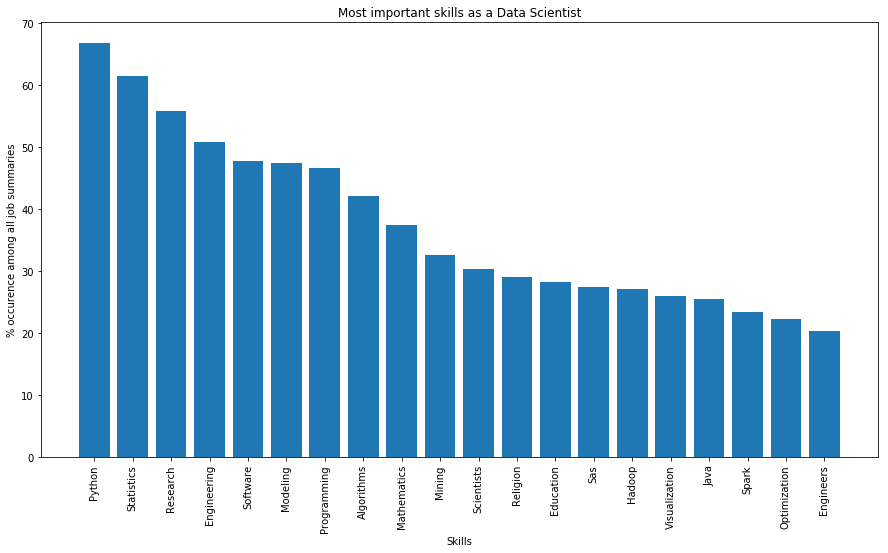

In [20]:
sk_ds = SkillsExtractor(df_ds, vocab_inter, 20, 'Data Scientist')
do_ds = sk_ds.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
The top 20 skills are :
1 : Reporting (46.42%)
2 : Research (38.11%)
3 : Statistics (37.85%)
4 : Software (37.34%)
5 : Education (33.50%)
6 : Engineering (29.67%)
7 : Python (27.75%)
8 : Databases (26.21%)
9 : Programming (25.06%)
10 : Religion (23.79%)
11 : Intelligence (23.15%)
12 : Modeling (23.02%)
13 : Tableau (22.12%)
14 : Training (21.23%)
15 : Mathematics (20.97%)
16 : Sas (20.59%)
17 : Visualization (19.69%)
18 : Writing (18.54%)
19 : Metrics (18.54%)
20 : Marketing (18.41%)


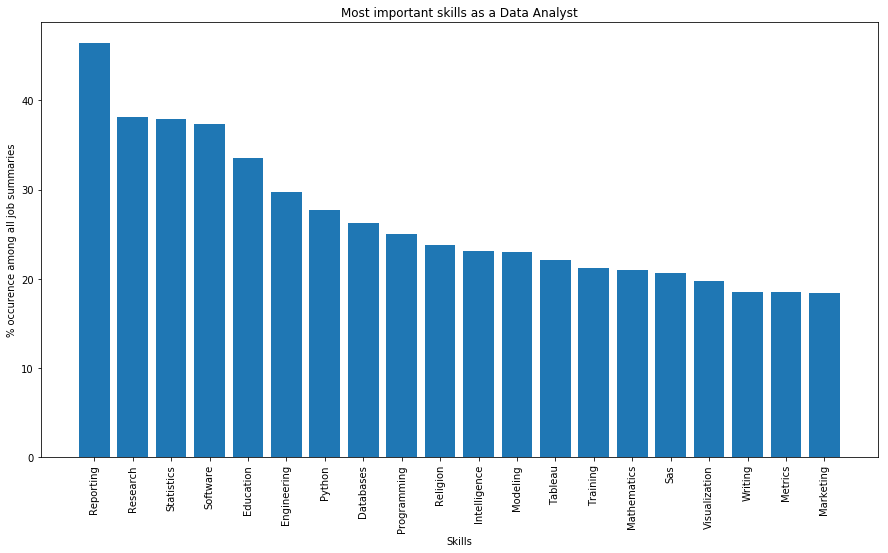

In [9]:
sk_da = SkillsExtractor(df_da, vocab_inter, 20, 'Data Analyst')
do_da = sk_da.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
Job description n°800
The top 10 skills are :
1 : Engineering (65.04%)
2 : Software (60.55%)
3 : Python (58.68%)
4 : Java (45.44%)
5 : Engineers (40.70%)
6 : Programming (39.70%)
7 : Hadoop (38.83%)
8 : Spark (37.45%)
9 : Infrastructure (29.59%)
10 : Databases (29.46%)


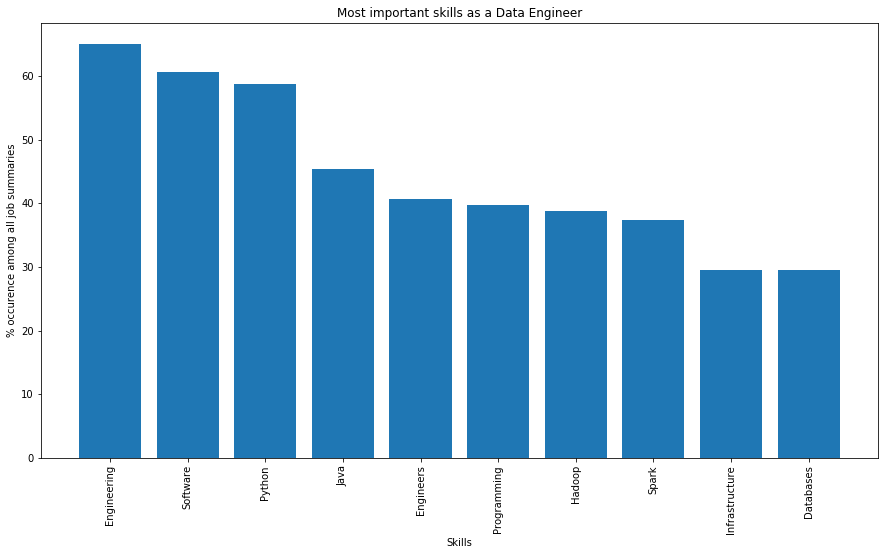

In [12]:
sk_de = SkillsExtractor(df_de, vocab_inter, 10, 'Data Engineer')
do_de = sk_de.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
The top 10 skills are :
1 : Intelligence (77.79%)
2 : Reporting (69.16%)
3 : Tableau (38.32%)
4 : Education (36.93%)
5 : Software (35.15%)
6 : Modeling (30.46%)
7 : Engineering (29.19%)
8 : Research (26.78%)
9 : Visualization (26.78%)
10 : Databases (26.65%)


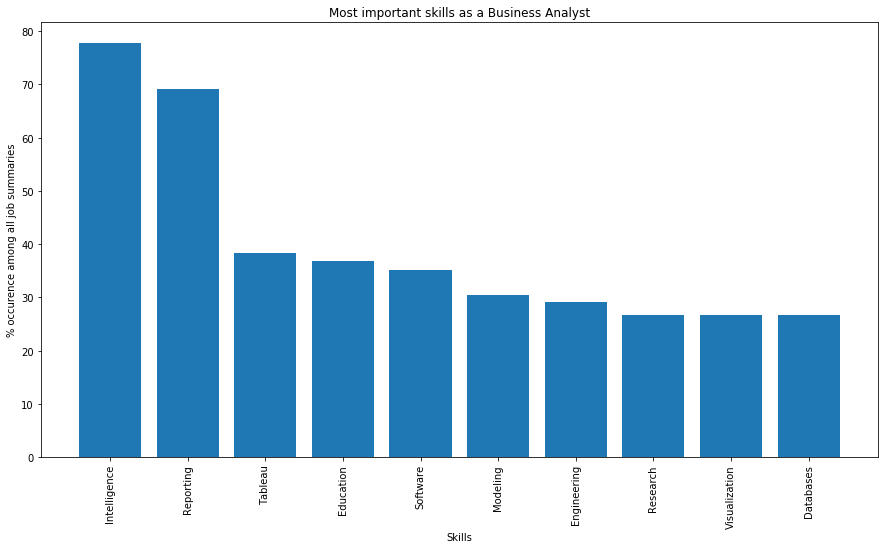

In [13]:
sk_bi = SkillsExtractor(df_bi, vocab_inter, 10, 'Business Analyst')
do_bi = sk_bi.get_top_skills()

## Extract skills paragraph

In [154]:
def get_skills_part(textfile):
    keywords = ['qualifications', 'skills', 'requirements', 'required', 'experience']
    signs = [':', '\n']
    
    skill_part_found = False
    
    for keyword in keywords:
        skills_part = textfile
        still_keyword = True
        
        while still_keyword:

            try:
                keyword_index = skills_part.lower().index(keyword)

                skills_part = skills_part[keyword_index:]
                test_sign = False
                for sign in signs:
                    try:
                        sign_index = skills_part.lower().index(sign)
                        if sign_index - len(keyword) < 15:
                            test_sign = True
                            break
                    except:
                        pass
                if test_sign == True:
                    if len(skills_part[len(keyword):]) > 100:
                        skill_part_found = True
                        break
                    else:
                        test_sign = False

                skills_part = skills_part[len(keyword):]
            except:
                still_keyword = False
        if skill_part_found:
            break
                
    if skill_part_found != True:
        print("No qualifications part found... \n")
        skills_part = 'No skills found'
        
    return skills_part

# LDA

## Without N grams

In [ ]:
df_raw = frames['summary'].values

In [73]:
# Filter words in a trivial way (stop words, max/min df)

tf_vectorizer_1gram = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{1,}\b', # more than 3 characters
                                max_df = 0.5,  # Ten that appear in more than 50% of documents
                                min_df = 50,
                                ) # Terms that appear in less than ten documents


tf_vectorizer_1gram.fit(df_raw) # Extract vocabulary from job descriptions
print(len(tf_vectorizer_1gram.vocabulary_))

# Returns intersection with Linkedin skills
vocab_inter = [k for k in tf_vectorizer_1gram.vocabulary_.keys() if k in skills_list]
print(len(vocab_inter))

# Computes count with relevant vocabulary

tf_vectorizer_1gram = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                vocabulary = vocab_inter, # CONSIDER ONLY RELEVANT VOCABULARY
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{1,}\b', # more than 3 characters
                                #max_df = 0.5,  # Taken into account previously
                                #min_df = 50,
                                ) 

dtm_tf = tf_vectorizer_1gram.fit_transform(df_raw)

2147
288


In [74]:
lda_tf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tf.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer_1gram)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      22.270345        1       1  0.243433 -0.025486
3      19.701294        1       2  0.009917 -0.226476
4      18.801971        1       3  0.028976  0.092142
2      15.349040        1       4  0.082962  0.123834
0      14.901153        1       5 -0.227564 -0.005151
5       8.976198        1       6 -0.137724  0.041136, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
198   Default  2921.000000       reporting  2921.000000  30.0000  30.0000
18    Default  2554.000000        research  2554.000000  29.0000  29.0000
10    Default   968.000000          hadoop   968.000000  28.0000  28.0000
67    Default  2594.000000    intelligence  2594.000000  27.0000  27.0000
9     Default   822.000000           spark   822.000000  26.0000  26.0000
7     Default   955.000000               c   955.000000  25.0000  25.0000
4     Default  3243.000000        software  3243.000000  24.0000  24.0000
101   Default   875.000000      healthcare   875.000000  23.0000  23.0000
132   Default   655.000000       insurance   655.000000  22.0000  22.0000
64    Default  1041.000000        security  1041.000000  21.0000  21.0000
25    Default  1778.000000          python  1778.000000  20.0000  20.0000
6     Default  1549.000000      statistics  1549.000000  19.0000  19.0000
5     Default  2644.000000     engineering  2644.000000  18.0000  18.0000
8     Default   889.000000            java   889.000000  17.0000  17.0000
57    Default  1172.000000       marketing  1172.000000  16.0000  16.0000
1     Default   945.000000      algorithms   945.000000  15.0000  15.0000
178   Default   306.000000          credit   306.000000  14.0000  14.0000
26    Default  1260.000000               r  1260.000000  13.0000  13.0000
28    Default  1493.000000     programming  1493.000000  12.0000  12.0000
29    Default   816.000000     integration   816.000000  11.0000  11.0000
34    Default   940.000000         tableau   940.000000  10.0000  10.0000
120   Default   710.000000         metrics   710.000000   9.0000   9.0000
129   Default   391.000000            hive   391.000000   8.0000   8.0000
0     Default   669.000000      scientists   669.000000   7.0000   7.0000
107   Default   799.000000             sas   799.000000   6.0000   6.0000
88    Default   870.000000       engineers   870.000000   5.0000   5.0000
181   Default   265.000000         capital   265.000000   4.0000   4.0000
83    Default   349.000000           scala   349.000000   3.0000   3.0000
130   Default   758.000000  infrastructure   758.000000   2.0000   2.0000
200   Default   616.000000           sales   616.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
185    Topic6    79.007330           video   194.693571   1.5087  -4.6360
270    Topic6    39.655987        wellness   100.231131   1.4834  -5.3253
257    Topic6    26.119378    corporations    66.679941   1.4734  -5.7429
99     Topic6    67.476162          matlab   181.018829   1.4238  -4.7938
141    Topic6    26.330078           numpy    73.693407   1.3814  -5.7348
15     Topic6   144.959522               d   428.498055   1.3268  -4.0291
201    Topic6    30.261743      relocation    90.003075   1.3206  -5.5957
212    Topic6    19.408186            nyse    60.970569   1.2659  -6.0399
244    Topic6    39.113754            html   123.328014   1.2622  -5.3391
273    Topic6    23.142825          github    76.858146   1.2103  -5.8639
128    Topic6    25.307715          docker    87.378921   1.1714  -5.7744
243    Topic6    41.273617             git   145.914629   1.1478  -5.2853
28     Topic6   365.711151     programming  1493.637668   1.0035  -3.1037
225    Topic6    71.664609      javascript   266.751495   1.0963  -4.7336
119    Topic6   105.734079            edge   42

## LDA with N Grams

In [77]:
# Filter words in a trivial way (stop words, max/min df)

tf_vectorizer_2grams = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{1,}\b', # more than 3 characters
                                max_df = 0.5,  # Ten that appear in more than 50% of documents
                                min_df = 50,
                                ngram_range = (1, 3)
                                ) # Terms that appear in less than ten documents


tf_vectorizer_2grams.fit(df_raw) # Extract vocabulary from job descriptions
print(len(tf_vectorizer_2grams.vocabulary_))

# Returns intersection with Linkedin skills
vocab_inter = [k for k in tf_vectorizer_2grams.vocabulary_.keys() if k in skills_list]
print(len(vocab_inter))

# Computes count with relevant vocabulary

tf_vectorizer_2grams = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                vocabulary = vocab_inter, # CONSIDER ONLY RELEVANT VOCABULARY
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{1,}\b', # more than 3 characters
                                ngram_range = (1, 3)
                                #max_df = 0.5,  # Taken into account previously
                                #min_df = 50,
                                ) 

dtm_tf = tf_vectorizer_2grams.fit_transform(df_raw)

3723
445


In [80]:
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer_2grams)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      30.841259        1       1 -0.183441  0.086372
3      25.294598        1       2  0.130135  0.127880
1      23.698963        1       3 -0.124939 -0.123331
0      20.165180        1       4  0.178246 -0.090921, topic_info=     Category         Freq                    Term        Total  loglift  \
term                                                                       
290   Default  3033.000000               reporting  3033.000000  30.0000   
16    Default  2292.000000        machine learning  2292.000000  29.0000   
273   Default  2027.000000   business intelligence  2027.000000  28.0000   
63    Default  1484.000000                big data  1484.000000  27.0000   
23    Default  2527.000000                research  2527.000000  26.0000   
10    Default   943.000000                  hadoop   943.000000  25.0000   
30    Default  1803.000000                  python  1803.000000  24.0000   
17    Default  1298.000000            data science  1298.000000  23.0000   
104   Default  2680.000000            intelligence  2680.000000  22.0000   
99    Default  1055.000000                security  1055.000000  21.0000   
1     Default  1008.000000              algorithms  1008.000000  20.0000   
9     Default   804.000000                   spark   804.000000  19.0000   
4     Default  3302.000000                software  3302.000000  18.0000   
5     Default  2663.000000             engineering  2663.000000  17.0000   
6     Default  1551.000000              statistics  1551.000000  16.0000   
8     Default   899.000000                    java   899.000000  15.0000   
187   Default   630.000000               insurance   630.000000  14.0000   
31    Default  1273.000000                       r  1273.000000  13.0000   
92    Default  1154.000000               marketing  1154.000000  12.0000   
135   Default   887.000000               engineers   887.000000  11.0000   
39    Default   927.000000                 tableau   927.000000  10.0000   
34    Default   830.000000             integration   830.000000   9.0000   
103   Default   802.000000            architecture   802.000000   8.0000   
153   Default   377.000000               pipelines   377.000000   7.0000   
184   Default   377.000000                    hive   377.000000   6.0000   
185   Default   755.000000          infrastructure   755.000000   5.0000   
0     Default   689.000000              scientists   689.000000   4.0000   
292   Default   605.000000                   sales   605.000000   3.0000   
152   Default   792.000000              healthcare   792.000000   2.0000   
105   Default   746.000000                  mining   746.000000   1.0000   
...       ...          ...                     ...          ...      ...   
222    Topic4    54.385070  continuous integration    64.120894   1.4365   
9      Topic4   682.664423                   spark   804.921843   1.4365   
207    Topic4    80.209938                  devops    94.670547   1.4355   
364    Topic4   121.431678                     git   143.861557   1.4317   
362    Topic4    59.108237         shell scripting    71.920121   1.4050   
357    Topic4    61.825249           data products    75.314109   1.4039   
63     Topic4  1187.296824                big data  1484.914205   1.3775   
182    Topic4   285.218343                   linux   357.620913   1.3750   
125    Topic4   274.405583                   scala   344.293925   1.3743   
8      Topic4   645.648652                    java   899.621715   1.2695   
339    Topic4   205.083897              javascript   276.169729   1.3036   
185    Topic4   484.754309          infrastructure   755.738852   1.1572   
203    Topic4   174.986386                    unix   233.821021   1.3114   
135    Topic4   513.389472               engineers   887.144780   1.0542   
242    Topic4   155.145356               ecosystem   206.0060

In [38]:
# lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)

# tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
# dtm_tfidf = tfidf_vectorizer.fit_transform(df_ds_raw)

# lda_tfidf.fit(dtm_tfidf)

In [39]:
# pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tf_vectorizer)